In [63]:
#Libraries
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

In [64]:
import pandas as pd

# load csv
df = pd.read_csv("/content/data.csv")

# write to required files
df["spanish"].to_csv("train.es", index=False, header=False)
df["english"].to_csv("train.en", index=False, header=False)


In [65]:
eng_file = '/content/train.en'
spanish_file = '/content/train.es'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(spanish_file, 'r') as file:
    spanish_sentences = file.readlines()

english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
spanish_sentences = [sentence.rstrip('\n') for sentence in spanish_sentences]


In [67]:
spanish_vocabulary = [
    ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
    '0','1','2','3','4','5','6','7','8','9', ':', '<', '=', '>', '?',
    '@',
    'a','b','c','d','e','f','g','h','i','j','k','l',
    'm','n','o','p','q','r','s','t','u','v','w','x','y','z',
    'á','é','í','ó','ú','ü','ñ','¿','¡',
    '[','\\',']','^','_','`','{','|','}','~'
]

english_vocabulary = [
    ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    ':', '<', '=', '>', '?', '@',
    '[', '\\', ']', '^', '_', '`',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z',
    '{', '|', '}', '~'
]


In [68]:
MAX_LEN = 40

spanish_sentences = open("train.es", encoding="utf-8").read().splitlines()
english_sentences = open("train.en", encoding="utf-8").read().splitlines()

valid_sentence_indicies = [
    i for i in range(len(english_sentences))
    if len(english_sentences[i].split()) <= MAX_LEN
    and len(spanish_sentences[i].split()) <= MAX_LEN
]


In [69]:
len(df)

118964

In [70]:
TOTAL_SENTENCES = 118964
x = [spanish_sentences[i] for i in valid_sentence_indicies]
y = [english_sentences[i] for i in valid_sentence_indicies]


In [71]:
import pandas as pd
dataset = pd.DataFrame({"Spanish": x, "English": y})
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118961 entries, 0 to 118960
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Spanish  118961 non-null  object
 1   English  118961 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [72]:
dataset.sample(5)

,Spanish,English
63651,Estás más linda que nunca.,You look as beautiful as ever.
24735,Mi colegio tiene una banda.,My school has a band.
59824,Deberías irte inmediatamente.,You should leave immediately.
23170,Todos saben eso.,Everybody knows that.
60914,No quiero reprobar en mis exámenes.,I don't want to fail my exams.


In [73]:
import os

save_dir = "/content/drive/MyDrive/Project_spanish"
os.makedirs(save_dir, exist_ok=True)
dataset.to_csv('/content/drive/MyDrive/Project_spanish/data.csv' , index = False )

In [74]:
dataset = pd.read_csv('/content/drive/MyDrive/Project_spanish/data.csv')
dataset.head()

,Spanish,English
0,Ve.,Go.
1,Vete.,Go.
2,Vaya.,Go.
3,Váyase.,Go.
4,Hola.,Hi.


In [76]:
text_pairs = []

for i in range(dataset.shape[0]):
    spanish = str(dataset["Spanish"][i])
    english = str(dataset["English"][i])
    text_pairs.append(
        (spanish, "[start] " + english + " [end]")
    )


In [77]:
len(text_pairs)


118961

In [78]:
train_sample_size = len(text_pairs) - int(0.1*len(text_pairs))
train_pairs = text_pairs[:train_sample_size]
test_pairs = text_pairs[train_sample_size:]

In [79]:
print("Total pairs :", len(text_pairs))
print("Train pairs :", len(train_pairs))
print("Test pairs :", len(test_pairs))

Total pairs : 118961
Train pairs : 107065
Test pairs : 11896


In [80]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

vocab_size = 35000
sequence_length = 30
batch_size = 64

In [81]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [82]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

es_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)


In [83]:
train_es_texts  = [pair[0] for pair in train_pairs]   # Spanish → encoder
train_eng_texts = [pair[1] for pair in train_pairs]   # English → decoder

es_vectorization.adapt(train_es_texts)
eng_vectorization.adapt(train_eng_texts)


In [84]:
import json

# Get the vocabulary
eng_vocab = eng_vectorization.get_vocabulary()
es_vocab = es_vectorization.get_vocabulary()

# Save the vocabulary
with open('/content/eng_vocab.json', 'w') as f:
    json.dump(eng_vocab, f)
with open('/content/es_vocab.json', 'w') as f:
    json.dump(es_vocab, f)


In [85]:
import json

vocab_size = 35000
sequence_length = 30
batch_size = 64

# Load the vocabulary
with open('/content/eng_vocab.json', 'r') as f:
    eng_vocab = json.load(f)
with open('/content/es_vocab.json', 'r') as f:
    es_vocab = json.load(f)

# Create a TextVectorization layer with the loaded vocabulary
eng_vectorization = TextVectorization(
    vocabulary=eng_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

es_vectorization = TextVectorization(
    vocabulary=es_vocab,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)


In [86]:
def format_dataset(spanish, english):
    spanish = es_vectorization(spanish)
    english = eng_vectorization(english)
    return (
        {
            "encoder_inputs": spanish,
            "decoder_inputs": english[:, :-1],
        },
        english[:, 1:],
    )


In [87]:
def make_dataset(pairs):
    spanish_texts, english_texts = zip(*pairs)
    spanish_texts = list(spanish_texts)
    english_texts = list(english_texts)
    dataset = tf.data.Dataset.from_tensor_slices((spanish_texts, english_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


In [88]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [89]:

for inputs, targets in train_ds.take(2):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 31)
inputs["decoder_inputs"].shape: (64, 29)
targets.shape: (64, 29)
inputs["encoder_inputs"].shape: (64, 31)
inputs["decoder_inputs"].shape: (64, 29)
targets.shape: (64, 29)


In [90]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [91]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
         return keras.ops.not_equal(inputs, 0)

In [107]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        # Causal self-attention (decoder side)
        causal_mask = self.get_causal_attention_mask(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # Cross-attention (NO causal/padding mask to avoid shape mismatch)
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_len = input_shape[0], input_shape[1]
        i = tf.range(seq_len)[:, tf.newaxis]
        j = tf.range(seq_len)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, seq_len, seq_len))
        return tf.tile(mask, [batch_size, 1, 1])


In [108]:
embed_dim = 256
latent_dim = 512
num_heads = 4

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:1474: UserWarning: Layer 'transformer_encoder_2' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''cannot access local variable 'padding_mask' where it is not associated with a value''
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder_2', however the layer does not have a `build()` method impleme

In [109]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [110]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_11' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [111]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  8,967,680 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,315,840 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_11       │ (None, None,      │ 20,330,936 │ decoder_inputs[0… │
│ (Functional)        │ 35000)            │            │ transformer_enco… │
│                     │                   │            │ not_equal_4[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,614,456 (116.78 MB)

 Trainable params: 30,614,456 (116.78 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

In [113]:
learning_rate = CustomSchedule(latent_dim)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)


Text(0.5, 0, 'Train Step')

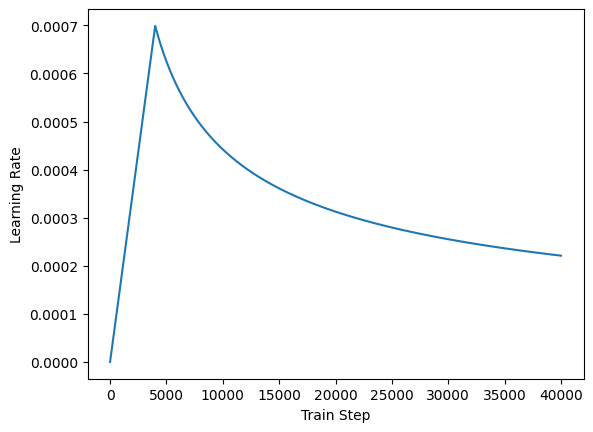

In [114]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [115]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
import os

drive_root = "/content/drive/MyDrive/spanish_transformer-1"

# Create directories if not exist
os.makedirs(drive_root, exist_ok=True)

checkpoint_filepath = os.path.join(drive_root, "checkpoint_spanish_transformer-1.keras")
csv_log_filepath = os.path.join(drive_root, "training_log_spanish_transformer-1.csv")
backup_dir = os.path.join(drive_root, "backup_spanish_transformer-1")
os.makedirs(backup_dir, exist_ok=True)


In [117]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

csv_logger = callbacks.CSVLogger(csv_log_filepath, append=True)

backup_callback = callbacks.BackupAndRestore(
    backup_dir=backup_dir,
    delete_checkpoint=False
)

all_callbacks = [early_stopping, model_checkpoint_callback, csv_logger, backup_callback]


In [118]:
epochs = 30
transformer.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [119]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ] )

Epoch 1/30
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 183s 99ms/step - accuracy: 0.1947 - loss: 7.4060 - val_accuracy: 0.1431 - val_loss: 4.5878
Epoch 2/30
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 159s 95ms/step - accuracy: 0.1437 - loss: 2.9570 - val_accuracy: 0.2076 - val_loss: 3.5696
Epoch 3/30
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 159s 95ms/step - accuracy: 0.1774 - loss: 2.0728 - val_accuracy: 0.2332 - val_loss: 3.2444
Epoch 4/30
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 159s 95ms/step - accuracy: 0.1940 - loss: 1.6373 - val_accuracy: 0.2413 - val_loss: 3.2217
Epoch 5/30
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 157s 94ms/step - accuracy: 0.2054 - loss: 1.3664 - val_accuracy: 0.2434 - val_loss: 3.2856
Epoch 6/30
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 150s 89ms/step - accuracy: 0.2134 - loss: 1.2220 - val_accuracy: 0.2507 - val_loss: 3.2337
Epoch 7/30
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 147s 88ms/step - accuracy: 0.2197 - loss: 1.1230 - val_accuracy: 0.2496 - val_loss: 3.3370
Epoch 8/30
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 149s 89ms/step - accuracy: 

In [120]:
transformer.save('/content/spanish.keras')


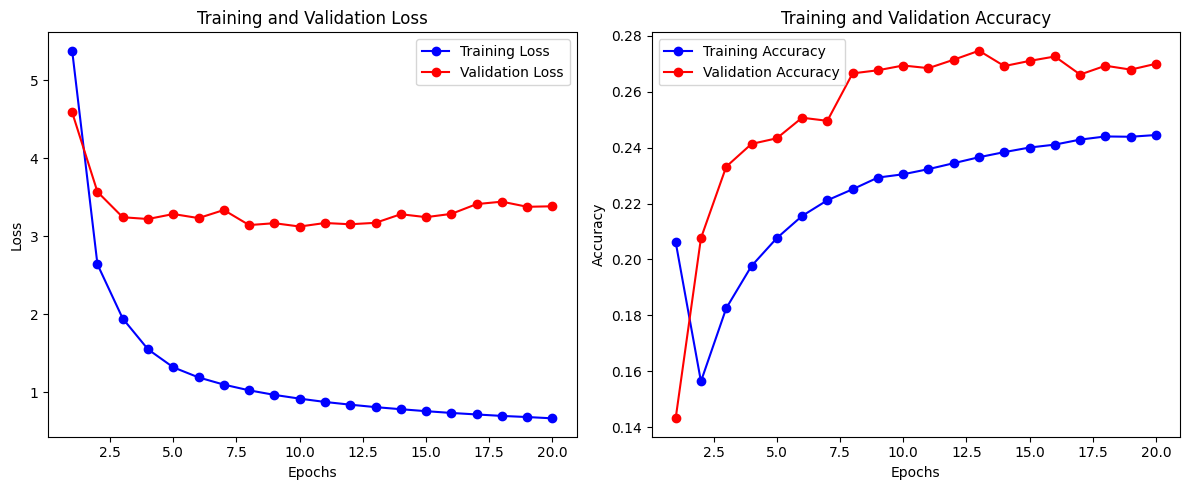

In [121]:
import os
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    plt.show()
plot_loss_and_accuracy(history ,"/content/drive/MyDrive/NMT-spanish", "spanish_loss.png" )

In [123]:
en_vocab = eng_vectorization.get_vocabulary()
en_index_lookup = dict(zip(range(len(en_vocab)), en_vocab))


In [124]:
for batch in test_ds.take(1):
    inputs, targets = batch
    predictions = transformer(inputs, training=False)
    break

predicted_ids = tf.argmax(predictions, axis=-1)

es_vocab = es_vectorization.get_vocabulary()
en_vocab = eng_vectorization.get_vocabulary()

def decode_tokens(token_ids, vocab):
    vocab = tf.constant(vocab)
    valid_tokens = tf.boolean_mask(token_ids, token_ids < tf.shape(vocab)[0])
    return " ".join([vocab[t].numpy().decode("utf-8") for t in valid_tokens if t != 0])


### Testing on Random Train Samples

In [130]:
for idx in range(10):
  encoder_input = inputs["encoder_inputs"][idx].numpy()
  ground_truth  = targets[idx].numpy()
  model_output  = predicted_ids[idx].numpy()


  print("Spanish (Input):")
  print(decode_tokens(encoder_input, es_vocab))

  print("\nEnglish (Ground Truth):")
  print(decode_tokens(ground_truth, en_vocab))

  print("\nEnglish (Model Output):")
  print(decode_tokens(model_output, en_vocab))


Spanish (Input):
¿crees que el revólver debiera hacerse ilegal

English (Ground Truth):
do you think that [UNK] should be made illegal end

English (Model Output):
do you think should should should be illegal illegal end end end end do do we we do do do do should we do do do do do
Spanish (Input):
¿todos piensan que yo robé el dinero

English (Ground Truth):
does everyone think it was me who stole the money end

English (Model Output):
does everyone think i stole stole to stole the money end end end does does can can does does does does everyone everyone everyone does does does does
Spanish (Input):
¿todos piensan que fui yo quien robó el dinero

English (Ground Truth):
does everyone think it was me who stole the money end

English (Model Output):
does everyone think i went me who stole the money end end end does everyone does thinks thinks everyone everyone thinks everyone everyone everyone everyone everyone everyone everyone
Spanish (Input):
no les culpes de lo que sucedió en boston
